In [2]:
# import necessary packages and modules
import numpy as np
import pandas as pd
#import clashroyale
from tqdm import tqdm_notebook as tqdm
from tqdm import trange
import time
from datetime import datetime
from dateutil import parser
import matplotlib.pyplot as plt
from functools import reduce
import ast #convert str representation of Dict to Dict/list to list

#from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns; 

%matplotlib inline

## Import data

In [3]:
Matches_PVP_Cleaned = pd.read_csv("cleaned_PVP_Matches.csv.csv")
Cards = pd.read_csv("Cards.csv.csv")
Matches_PVP_Cleaned.sample(5)

,Unnamed: 0,mode,opponentCrowns,opponentDeck,opponentTag,opponentTrophies,teamCrowns,teamDeck,teamSize,teamTag,teamTrophies,type,utcTime,winner
18898,38312,"{'name': 'Ladder', 'deck': 'Collection', 'card...",3,"[[26000024, 13], [26000042, 2], [26000005, 12]...",QVGVYPJ,3878.0,1,"[[26000035, 1], [26000042, 2], [26000020, 5], ...",1,22QVJ2JRG,3881.0,PvP,1531900501,-2
7327,14998,"{'name': 'Ladder', 'deck': 'Collection', 'card...",1,"[[26000011, 8], [26000001, 9], [26000013, 9], ...",9QCUP22U2,3643.0,0,"[[27000006, 11], [26000004, 5], [27000003, 8],...",1,8PJJRC2U2,3649.0,PvP,1531921572,-1
57473,115598,"{'name': 'Ladder', 'deck': 'Collection', 'card...",1,"[[28000008, 11], [26000053, 10], [26000046, 2]...",QQ2YJQ80,4086.0,2,"[[26000024, 12], [28000001, 12], [28000000, 10...",1,2V2CLRCRC,4097.0,PvP,1531968323,1
58736,118423,"{'name': 'Ladder', 'deck': 'Collection', 'card...",1,"[[26000014, 4], [26000009, 2], [26000019, 5], ...",PPGRQY8UC,1086.0,1,"[[26000003, 3], [26000016, 1], [28000000, 4], ...",1,9U0LRV8QG,1120.0,PvP,1532017666,0
5281,10403,"{'name': 'Ladder', 'deck': 'Collection', 'card...",0,"[[26000001, 12], [26000002, 12], [26000038, 9]...",2Y8GGC0U9,4120.0,1,"[[26000017, 9], [27000010, 10], [26000035, 3],...",1,2QPLQL88J,4094.0,PvP,1531915523,1


In [4]:
## data are imported all in str type
## convert imported str representation of List/dict to actual list/dict type
Matches_PVP_Cleaned["mode"] = Matches_PVP_Cleaned["mode"].apply(lambda x: ast.literal_eval(x))
Matches_PVP_Cleaned.loc[:,"teamDeck"] = Matches_PVP_Cleaned["teamDeck"].apply(lambda x: ast.literal_eval(x))
Matches_PVP_Cleaned["opponentDeck"] = Matches_PVP_Cleaned["opponentDeck"].apply(lambda x: ast.literal_eval(x))

### Get training set and test set and prepare dummy values

I am going to start with converting cards list into **dummy categorical variables** into Matches_PVP_Cleaned dataframe.

In [5]:
##get the name of the output dummy values column name.
teamDeck_dumy_name =[]
for item in Matches_PVP_Cleaned.teamDeck:
    for lst in item:
        if lst[0] not in teamDeck_dumy_name:
            teamDeck_dumy_name.append(lst[0])
        if len(teamDeck_dumy_name)>=86:
            break

In [6]:
# Create a all zero matrix to insert values. I was told this insertion to zero matrix way is faster then directly creating matrix out of the data way.
teamDeck_dummy =pd.DataFrame(np.zeros((len(Matches_PVP_Cleaned.teamDeck), len(teamDeck_dumy_name)), dtype=np.int), columns=sorted(teamDeck_dumy_name))

opponentDeck_dummy = pd.DataFrame(np.zeros((len(Matches_PVP_Cleaned.opponentDeck), len(teamDeck_dumy_name)), dtype=np.int), columns=sorted(teamDeck_dumy_name))
#teamDeck_dummy.head()

In [7]:
#insert data into the the zero matrix.
# Something to note for future reference, at function is way much faster than loc function for inserting values. 
# here at function only takes 5 seconds to complete the loop where loc function would take 18 hours and up.
with tqdm(total=len(Matches_PVP_Cleaned.teamDeck), initial=0) as pbar:
    for idx, lst in enumerate(Matches_PVP_Cleaned.teamDeck):
        for item in lst:
            teamDeck_dummy.at[idx,item[0]]= item[1]
        pbar.update()

In [8]:
with tqdm(total=len(Matches_PVP_Cleaned.opponentDeck), initial=0) as pbar:
    for idx, lst in enumerate(Matches_PVP_Cleaned.opponentDeck):
        for item in lst:
            opponentDeck_dummy.at[idx,item[0]]= item[1]
        pbar.update()

Verify dummy variables.

In [9]:
# Check if every row has 8 data, by checking if any row does not have 78 0s.
## rationale: There are 86 columns(cards in the game) 
## only 8 cards are drawn for each battle
## so I count for number of zeros for each rows(transpose to column) and it should return 78 (86-8)
## so then I check if the counted 0's is equal to 78.

#assert(any((teamDeck_dummy.T.apply(lambda x:x.value_counts(0))).loc[0,:]-78) == False)
#assert(any((opponentDeck_dummy.T.apply(lambda x:x.value_counts(0))).loc[0,:]-78) == False)

In [10]:
teamDeck_dummy.shape

(59538, 86)

In [11]:
#define a function that translate card id to card name
def cardIdToData(Id):
    if isinstance(Id,list):
        return ([Cards["name"][Cards.id == item].values[0] for item in Id])
            #print(Cards["name"][Cards.id == item])
    else:
        return(Cards["name"][Cards.id == Id].values[0])
cardIdToData(26000012)

'Skeleton Army'

In [12]:
#turn card id to card names
teamDeck_dummy.columns = cardIdToData(teamDeck_dummy.columns.tolist())
opponentDeck_dummy.columns = cardIdToData(opponentDeck_dummy.columns.tolist())

build 3 training and testing set based on unnormalized, dummy variable on levels, and weighted based on wining rate.

### Weighted to Winng rate

In [13]:
teamDeck_dummy = pd.concat([teamDeck_dummy,Matches_PVP_Cleaned.winner.reset_index(drop=True)],axis=1)
#opponentDeck_dummy = pd.concat([teamDeck_dummy,Matches_PVP_Cleaned.winner.reset_index(drop=True)],axis=1)

In [14]:
def get_wining_rate(card):
    return len(teamDeck_dummy[teamDeck_dummy[card]!=0][teamDeck_dummy[teamDeck_dummy[card]!=0].winner.astype(int)>0].winner )/len(teamDeck_dummy[teamDeck_dummy[card]!=0])
cards_wining_rate = teamDeck_dummy.columns.to_series().apply(get_wining_rate)[:-1]

In [17]:
teamDeck_dummy_weighted=teamDeck_dummy.copy()
opponentDeck_dummy_weighted=opponentDeck_dummy.copy()
for i,item in enumerate(cards_wining_rate.values):
    teamDeck_dummy_weighted.iloc[:,i] = teamDeck_dummy.iloc[:,i].mul(int(round(item,2)*100))
    opponentDeck_dummy_weighted.iloc[:,i] = opponentDeck_dummy.iloc[:,i].mul(int(round(item,2)*100))
display(teamDeck_dummy_weighted.sample(5))
display(opponentDeck_dummy_weighted.sample(5))

,Knight,Archers,Goblins,Giant,P.E.K.K.A,Minions,Balloon,Witch,Barbarians,Golem,...,Zap,Poison,Graveyard,The Log,Tornado,Clone,Barbarian Barrel,Heal,Giant Snowball,winner
53678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,94,0,0,0,0,0,1
16813,288,336,0,196,0,0,0,92,0,0,...,0,0,0,0,0,0,0,0,0,-1
16956,0,0,0,0,0,0,0,0,0,0,...,624,0,0,0,0,0,0,0,0,1
963,0,192,225,196,0,0,47,92,0,0,...,0,0,0,0,0,0,0,0,0,-2
38629,0,0,0,0,184,0,0,184,0,0,...,432,0,0,0,0,0,0,0,0,1


,Knight,Archers,Goblins,Giant,P.E.K.K.A,Minions,Balloon,Witch,Barbarians,Golem,...,Lightning,Zap,Poison,Graveyard,The Log,Tornado,Clone,Barbarian Barrel,Heal,Giant Snowball
49529,0,0,0,0,0,0,329,0,0,0,...,0,576,0,0,0,0,0,0,0,0
9868,0,0,0,0,0,0,0,184,0,0,...,0,0,0,0,0,0,0,0,0,0
12819,0,0,0,0,0,0,94,0,240,0,...,0,0,0,0,0,0,0,0,0,0
47149,0,0,0,0,0,0,0,0,0,0,...,230,0,0,0,0,0,0,0,0,0
21921,0,0,495,0,0,539,0,0,0,0,...,0,528,0,0,0,0,0,0,0,0


### dummy variables to each card level

In [18]:
teamDeck_dummy_to_level = pd.get_dummies(teamDeck_dummy.drop("winner",axis=1).applymap(str))
opponentDeck_dummy_to_level = pd.get_dummies(opponentDeck_dummy.applymap(lambda x:str(-x)))

In [19]:
opponentDeck_dummy_to_level.columns = opponentDeck_dummy_to_level.columns.to_series().apply(lambda x:"op"+x).values
#pd.get_dummies(teamDeck_dummy.drop("winner",axis=1))

In [55]:
X = pd.concat([teamDeck_dummy.drop("winner",axis=1),opponentDeck_dummy],axis=1)#.apply(str)
X_level = pd.concat([teamDeck_dummy_to_level,opponentDeck_dummy_to_level],axis=1)
X_weighted = pd.concat([teamDeck_dummy_weighted.drop("winner",axis=1),opponentDeck_dummy_weighted],axis=1)

y = Matches_PVP_Cleaned.winner.reset_index(drop=True)
y = y.apply(lambda x:0 if int(x)<=0 else 1).apply(int)

In [56]:
## I prefer data with each level extracted to dummy variable, start train_test_split with that.
X_train, X_test, y_train, y_test = (train_test_split(X_level, y, test_size=0.2, random_state=42))

## 2 layer neural network trainng setup

Following is a part of the copy of my homework 3 on coursera "Neural Networks and Deep Learning" course.

### Forward Propagation
Forward Propagation needs Z, A, and parmeters W, b
First we define parameters.
- W1, b1 will be matrix randomly initialized by the size of input 
- W2, b2 will be matrix randomly initialized by the size of first hidden layer

Second, we used above parameters to calculate Z and A
- Z1 = np.dot(W1, X) + b1
- A1 = g1(Z1) = tanh(Z1)
- Z2 = np.dot(W2, Z2) + b2
- A2 = g2(Z2) = sigmoid(Z2)

In [23]:
#Forward Propogation
## firstly, calculate the parameters, in order to do so, we need the dimension of the input data

## dimensions
def layer_sizes(X, Y):
    m = X.shape[1]    # example size
    n_x = X.shape[0]  # size of input
    n_h = 4           # size of hidden layer
    n_y = Y.shape[0]  # size of output
    return (n_x, n_h, n_y)

# W1, b1, W2, b2
def initialize_parameters(n_x, n_h, n_y):
    
    np.random.seed(2)
    
    W1 = np.random.randn(n_h, n_x) * 0.01 ## multiplied by 0.01 in order to have smaller initialized value. to have faster learning rate through gradient descent.
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01 
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def sigmoid(z):
    return 1/(1+np.exp(-z))

def forward_propagation(X, parameters):
    # retrieve values from parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # forward propogation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

Cost Function
Cost function is given by 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$


In [24]:
#Cost function
def compute_cost(A2, Y, parameters):
    m = Y.shape[1]
    cost = np.multiply((- 1/m), np.sum(np.multiply(Y, np.log(A2))+np.multiply((1-Y),np.log(1-A2))))
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

### Backward Propagation & Gradient Descent
Backward propagation ultimately only needs dW, db, but in order to calculate this 2 parameter, we need dZ
<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [27]:
## backward Propagation
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1]
    A1 = cache["A1"]
    A2 = cache["A2"]
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis = 1, keepdims=True)
    dZ1 = np.dot(W2.T, dZ2) * (1-np.power(A1, 2)) 
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis = 1, keepdims=True)
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False, learning_rate = 2.0):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

def predict(parameters, X):
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > 0.5
    ### END CODE HERE ###
    
    return predictions

In [57]:
y_train = y_train.values.reshape((y_train.values.shape[0],1))

In [58]:
X_train.values.T.shape, y_train.T.shape

((1796, 47630), (1, 47630))

In [ ]:
nn_model(X_train.values.T, y_train.T, 4, num_iterations=10000, print_cost=True, learning_rate=0.2)

Cost after iteration 0: 0.693068


## Visualize card usage

In [ ]:
sns.reset_orig()
teamDeck_dummy.columns[0:-1].to_series().apply(get_wining_rate).to_frame().sort_values(by=0).plot(kind="barh",figsize=(10,20))
plt.xlim(0.35,0.5)
plt.title("Card wining rate")

In [ ]:
#define a function that translate card id to card icon link
def cardNameToLink(name):
    icon = Cards[Cards["name"] == name].icon.values[0]
    return icon

yticklabeltext = opponentDeck_dummy.apply(lambda x: x.value_counts())[1:13].fillna(0).sum().sort_values().index

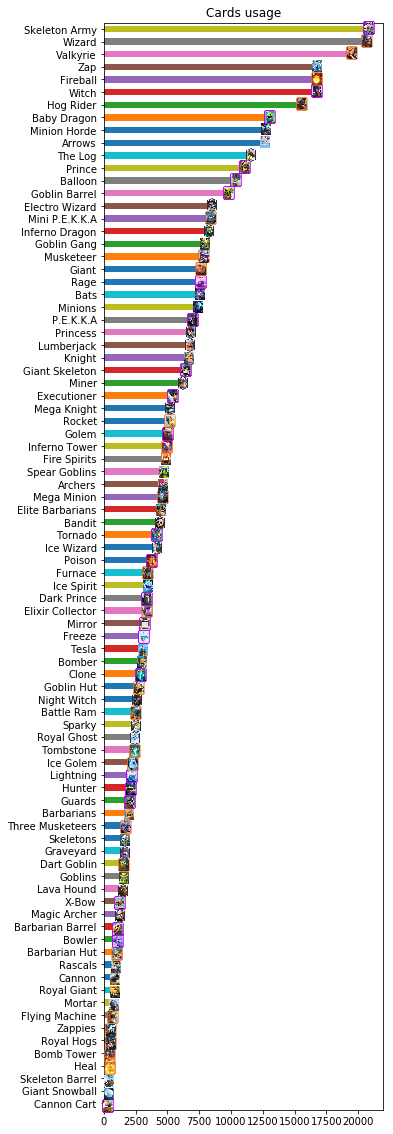

In [16]:
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
fig, ax = plt.subplots()
#xy = (0.5, 0.7)
ax = opponentDeck_dummy.apply(lambda x: x.value_counts())[1:13].fillna(0).sum().sort_values().plot(kind="barh",figsize = (5,20))

for p in ax.patches:
    url = cardNameToLink(yticklabeltext[int(p.get_y()+0.25)])
    img=mpimg.imread(url)

    xy = (p.get_width()/80+1,p.get_y()*0.93)
    imagebox = OffsetImage(img, zoom=0.04)
    imagebox.image.axes = ax
    #ax.annotati==()
    ab = AnnotationBbox(imagebox, xy,
                        xycoords='data',
                        boxcoords="offset points",
                        pad=-1,

                        )

    ax.add_artist(ab)
    #print(xy)
plt.title("Cards usage")
plt.savefig("clash royale card usage.png")
# for item in ax.get_yticklabels():
#     print((item))